This dataset is great for learning BigQuery. It's so small that in practice you'll never be able to hit any query limits so you can run as many tests as you want.

I'll show you how to run a simple query against BigQuery and export the results to Pandas. We'll start with a helper library that lets us do this in one line and then move on to exploring how that function works.

If you're looking to get started quickly you can just use bq_helper to execute a SQL query. When you're ready to dig deeper the [full BigQuery SQL reference is here](https://cloud.google.com/bigquery/docs/reference/standard-sql/).

In [5]:
import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper

In [6]:
# sample query from:
# https://cloud.google.com/bigquery/public-data/openaq#which_10_locations_have_had_the_worst_air_quality_this_month_as_measured_by_high_pm10
QUERY = """
        SELECT location, city, country, value, timestamp
        FROM `bigquery-public-data.openaq.global_air_quality`
        WHERE pollutant = "pm10" AND timestamp > "2017-04-01"
        ORDER BY value DESC
        LIMIT 1000
        """

The quick way to execute this query is to use [the bq_helper library](https://github.com/SohierDane/BigQuery_Helper):

In [7]:
bq_assistant = BigQueryHelper('bigquery-public-data', 'openaq')
df = bq_assistant.query_to_pandas(QUERY)
df.head(3)

,location,city,country,value,timestamp
0,Urgakh naran,Ulaanbaatar,MN,8782.0,2018-02-06 15:15:00+00:00
1,Dilovası,Kocaeli,TR,5243.0,2018-01-25 12:00:00+00:00
2,Chaiten Norte,Chaitén,CL,1000.0,2018-02-05 09:00:00+00:00


But what is bq_helper actually doing under the hood? Let's replicate the same process through the core BigQuery API to find out.

In [8]:
client = bigquery.Client()
query_job = client.query(QUERY)
rows = list(query_job.result(timeout=30))
for row in rows[:3]:
    print(row)

Row(('Urgakh naran', 'Ulaanbaatar', 'MN', 8782.0, datetime.datetime(2018, 2, 6, 15, 15, tzinfo=<UTC>)), {'location': 0, 'city': 1, 'country': 2, 'value': 3, 'timestamp': 4})
Row(('Dilovası', 'Kocaeli', 'TR', 5243.0, datetime.datetime(2018, 1, 25, 12, 0, tzinfo=<UTC>)), {'location': 0, 'city': 1, 'country': 2, 'value': 3, 'timestamp': 4})
Row(('Chaiten Norte', 'Chaitén', 'CL', 1000.0, datetime.datetime(2018, 2, 5, 9, 0, tzinfo=<UTC>)), {'location': 0, 'city': 1, 'country': 2, 'value': 3, 'timestamp': 4})


The outputs look reasonable, but what's this storage format?

In [9]:
type(rows[0])

google.cloud.bigquery.table.Row

Per the [BigQuery Python API documentation](https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html?highlight=google%20cloud%20bigquery%20table%20row#google.cloud.bigquery.table.Row), it turns out that  we can access the labels and data separately. This will allow us to make a clean export to pandas.

In [10]:
list(rows[0].keys())

['location', 'city', 'country', 'value', 'timestamp']

In [11]:
list(rows[0].values())

['Urgakh naran',
 'Ulaanbaatar',
 'MN',
 8782.0,
 datetime.datetime(2018, 2, 6, 15, 15, tzinfo=<UTC>)]

In [12]:
df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

In [16]:
df.head(3)

,location,city,country,value,timestamp
0,Urgakh naran,Ulaanbaatar,MN,8782.0,2018-02-06 15:15:00+00:00
1,Dilovası,Kocaeli,TR,5243.0,2018-01-25 12:00:00+00:00
2,Chaiten Norte,Chaitén,CL,1000.0,2018-02-05 09:00:00+00:00


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
location     1000 non-null object
city         1000 non-null object
country      1000 non-null object
value        1000 non-null float64
timestamp    1000 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 39.1+ KB


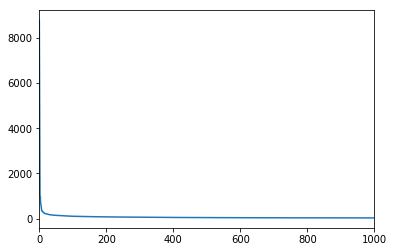

In [15]:
df['value'].plot()

At the time of writing, the single most polluted site was a small town in rural Chile. I thought that had to be a problem with the data but it turns out [to be plausible](http://www.coha.org/the-battle-to-breathe-chiles-toxic-threat/) due to wildfires generating a lot of smoke and a severe drought causing smog to linger. The most polluted sites are an order of magnitude worse than the other cities, so I hope for their sake that it's a transient problem!